In [1]:
# Step 0. 导入依赖
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Step 1. 读取数据
file_path = "C:/Users/Candy/Desktop/merged_all.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")
print("原始数据规模:", df.shape)

# Step 2. 计算平均血压
df["sbp_mean"] = df[["bp1systolic1", "bp1systolic2", "bp1systolic3"]].mean(axis=1, skipna=True)
df["dbp_mean"] = df[["bp1diastolic1", "bp1diastolic2", "bp1diastolic3"]].mean(axis=1, skipna=True)

# Step 3. 血压分组 (ESC/ESH 标准)
def classify_bp(sbp, dbp):
    if pd.isna(sbp) or pd.isna(dbp):
        return np.nan
    if sbp < 120 and dbp < 80:
        return "optimal"
    elif sbp < 130 and dbp < 85:
        return "normal"
    elif sbp < 140 and dbp < 90:
        return "high_normal"
    else:
        return "hypertensive"

df["bp_group"] = df.apply(lambda row: classify_bp(row["sbp_mean"], row["dbp_mean"]), axis=1)


原始数据规模: (100059, 16)


In [2]:
# 删除缺失 outcome
df = df.dropna(subset=["bp_group"])
print("清洗后数据规模:", df.shape)

清洗后数据规模: (66560, 19)


In [3]:
# Step 4. 编码 outcome
bp_mapping = {"optimal":0, "normal":1, "high_normal":2, "hypertensive":3}
df["bp_group_code"] = df["bp_group"].map(bp_mapping)


In [4]:
# Step 5. 协变量处理
X = df[["intage", "bmi", "gender", "ethderived"]].copy()

# 标准化连续变量
scaler = StandardScaler()
X[["intage", "bmi"]] = scaler.fit_transform(X[["intage", "bmi"]])

# 编码分类变量 (gender, ethderived)
X["gender"] = X["gender"].astype("category").cat.codes   # 0=male, 1=female
X["ethderived"] = X["ethderived"].astype("category").cat.codes  # 1=Chinese, 2=Malay, 3=Indian, 4=Others

y = df["bp_group_code"]

print("自变量矩阵:", X.shape, "目标变量:", y.shape)

自变量矩阵: (66560, 4) 目标变量: (66560,)


In [6]:
# 去掉含有 NaN 的样本
X = X.dropna()
y = y.loc[X.index]   # 保持 y 对齐

print("去掉缺失后的样本量:", X.shape[0])

去掉缺失后的样本量: 66474


In [7]:
# Step 6. 拟合多项 logistic 回归
clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
clf.fit(X, y)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [8]:
# Step 7. 输出参数
print("截距 (intercepts):")
print(clf.intercept_)

print("\n回归系数 (coefficients):")
coef_table = pd.DataFrame(clf.coef_, 
                          columns=["intage_z","bmi_z","gender","ethderived"], 
                          index=["optimal","normal","high_normal","hypertensive"])
print(coef_table)

截距 (intercepts):
[ 0.80911711 -0.0480997  -0.41256502 -0.34845239]

回归系数 (coefficients):
              intage_z     bmi_z    gender  ethderived
optimal      -0.676266 -0.421689  0.343333    0.063876
normal       -0.180020  0.028815 -0.170292   -0.003221
high_normal   0.209493  0.156204 -0.129227   -0.031857
hypertensive  0.646793  0.236670 -0.043814   -0.028798


In [9]:
# Step 8. 模型评估
y_pred = clf.predict(X)
print("\n分类准确率:", clf.score(X, y))
print("\n分类报告 (Classification Report):")
print(classification_report(y, y_pred, target_names=bp_mapping.keys()))


分类准确率: 0.5635737280741342

分类报告 (Classification Report):
              precision    recall  f1-score   support

     optimal       0.60      0.92      0.73     36075
      normal       0.18      0.00      0.01     10445
 high_normal       0.00      0.00      0.00      8194
hypertensive       0.39      0.37      0.38     11760

    accuracy                           0.56     66474
   macro avg       0.29      0.32      0.28     66474
weighted avg       0.42      0.56      0.46     66474



C:\01project\condapy310\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\01project\condapy310\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\01project\condapy310\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# one hot尝试

In [10]:
# Step 0. 导入依赖
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Step 1. 读取数据
file_path = "C:/Users/Candy/Desktop/merged_all.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Step 2. 计算平均血压
df["sbp_mean"] = df[["bp1systolic1", "bp1systolic2", "bp1systolic3"]].mean(axis=1, skipna=True)
df["dbp_mean"] = df[["bp1diastolic1", "bp1diastolic2", "bp1diastolic3"]].mean(axis=1, skipna=True)

def classify_bp(sbp, dbp):
    if pd.isna(sbp) or pd.isna(dbp):
        return np.nan
    if sbp < 120 and dbp < 80:
        return "optimal"
    elif sbp < 130 and dbp < 85:
        return "normal"
    elif sbp < 140 and dbp < 90:
        return "high_normal"
    else:
        return "hypertensive"

df["bp_group"] = df.apply(lambda row: classify_bp(row["sbp_mean"], row["dbp_mean"]), axis=1)
df = df.dropna(subset=["bp_group"])  # 删除缺失 outcome

# 编码 outcome
bp_mapping = {"optimal":0, "normal":1, "high_normal":2, "hypertensive":3}
df["bp_group_code"] = df["bp_group"].map(bp_mapping)

# Step 3. 协变量处理
# 连续变量标准化
scaler = StandardScaler()
df[["intage","bmi"]] = scaler.fit_transform(df[["intage","bmi"]])

# 性别转数字
df["gender"] = df["gender"].astype("category").cat.codes  # 0=male,1=female

# 种族 one-hot 编码（drop_first=True 避免共线性）
df = pd.get_dummies(df, columns=["ethderived"], drop_first=True)

# Step 4. 构建 X, y
X = df[["intage","bmi","gender"] + [col for col in df.columns if col.startswith("ethderived_")]]
y = df["bp_group_code"]

# 丢掉 NaN
X = X.dropna()
y = y.loc[X.index]

print("最终建模样本量:", X.shape[0])

# Step 5. 拟合模型（加权）
clf = LogisticRegression(
    multi_class="multinomial", 
    solver="lbfgs", 
    max_iter=1000,
    class_weight="balanced"
)
clf.fit(X, y)

# Step 6. 输出参数
coef_table = pd.DataFrame(
    clf.coef_, 
    columns=X.columns, 
    index=["optimal","normal","high_normal","hypertensive"]
)

print("\n截距 (intercepts):")
print(clf.intercept_)
print("\n回归系数 (coefficients):")
print(coef_table)

# Step 7. 模型评估
y_pred = clf.predict(X)
print("\n分类准确率:", clf.score(X, y))
print("\n分类报告 (Classification Report):")
print(classification_report(y, y_pred, target_names=bp_mapping.keys()))


最终建模样本量: 66474

截距 (intercepts):
[-0.17996352  0.23554609  0.12593514 -0.18151771]

回归系数 (coefficients):
                intage       bmi    gender  ethderived_2  ethderived_3  \
optimal      -0.721620 -0.443456  0.431489     -0.124772      0.151361   
normal       -0.181146  0.029924 -0.160200     -0.019441     -0.009802   
high_normal   0.222797  0.167414 -0.160847     -0.009179     -0.069784   
hypertensive  0.679970  0.246118 -0.110441      0.153392     -0.071774   

              ethderived_4  
optimal           0.293161  
normal            0.041385  
high_normal      -0.103530  
hypertensive     -0.231015  

分类准确率: 0.4845052200860487

分类报告 (Classification Report):
              precision    recall  f1-score   support

     optimal       0.75      0.60      0.67     36075
      normal       0.21      0.22      0.21     10445
 high_normal       0.18      0.13      0.15      8194
hypertensive       0.34      0.60      0.44     11760

    accuracy                           0.48     6

In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Step 1. 读取数据
file_path = "C:/Users/Candy/Desktop/merged_all.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

print("原始数据规模:", df.shape)

# Step 2. 计算平均血压
df["sbp_mean"] = df[["bp1systolic1", "bp1systolic2", "bp1systolic3"]].mean(axis=1, skipna=True)
df["dbp_mean"] = df[["bp1diastolic1", "bp1diastolic2", "bp1diastolic3"]].mean(axis=1, skipna=True)

# 血压分组函数
def classify_bp(sbp, dbp):
    if pd.isna(sbp) or pd.isna(dbp):
        return np.nan
    if sbp < 120 and dbp < 80:
        return "optimal"
    elif sbp < 130 and dbp < 85:
        return "normal"
    elif sbp < 140 and dbp < 90:
        return "high_normal"
    else:
        return "hypertensive"

df["bp_group"] = df.apply(lambda row: classify_bp(row["sbp_mean"], row["dbp_mean"]), axis=1)
df = df.dropna(subset=["bp_group"])  # 删除缺失 outcome

# 编码 outcome
bp_mapping = {"optimal":0, "normal":1, "high_normal":2, "hypertensive":3}
df["bp_group_code"] = df["bp_group"].map(bp_mapping)

print("分组后数据规模:", df.shape)

# Step 3. 协变量处理
# 标准化连续变量
scaler = StandardScaler()
df[["intage","bmi"]] = scaler.fit_transform(df[["intage","bmi"]])

# 性别编码
df["gender"] = df["gender"].astype("category").cat.codes  # 0=male,1=female

# 种族 one-hot 编码
df = pd.get_dummies(df, columns=["ethderived"], drop_first=True)

# 性别 × 种族交互项
for col in [c for c in df.columns if c.startswith("ethderived_")]:
    df[f"genderX{col}"] = df["gender"] * df[col]

# 构建特征矩阵
feature_cols = ["intage","bmi","gender"] + \
               [c for c in df.columns if c.startswith("ethderived_")] + \
               [c for c in df.columns if c.startswith("genderX")]

X = df[feature_cols]
y = df["bp_group_code"]

# Step 4. 去掉 NaN
mask = X.notnull().all(axis=1)
X = X.loc[mask]
y = y.loc[mask]

print("最终建模样本量:", X.shape[0])

# Step 5. Logistic 回归 (balanced)
clf = LogisticRegression(
    multi_class="multinomial", 
    solver="lbfgs", 
    max_iter=1000, 
    class_weight="balanced"
)
clf.fit(X, y)

# Step 6. 输出系数 + OR
coef_table = pd.DataFrame(
    clf.coef_, columns=feature_cols, 
    index=["optimal","normal","high_normal","hypertensive"]
)

or_table = np.exp(coef_table)  # odds ratio

print("\n回归系数 (coefficients):")
print(coef_table.round(3))

print("\nOdds Ratios (OR):")
print(or_table.round(3))

# Step 7. 模型评估
y_pred = clf.predict(X)
print("\n分类准确率:", clf.score(X, y))
print("\n分类报告:")
print(classification_report(y, y_pred, target_names=bp_mapping.keys()))


原始数据规模: (100059, 16)
分组后数据规模: (66560, 20)
最终建模样本量: 66474

回归系数 (coefficients):
              intage    bmi  gender  ethderived_2  ethderived_3  ethderived_4  \
optimal       -0.722 -0.444   0.425        -0.090         0.093         0.397   
normal        -0.181  0.031  -0.154        -0.004         0.000         0.022   
high_normal    0.223  0.168  -0.158        -0.043        -0.029        -0.150   
hypertensive   0.680  0.246  -0.113         0.137        -0.064        -0.268   

              genderXethderived_2  genderXethderived_3  genderXethderived_4  
optimal                    -0.057                0.108               -0.182  
normal                     -0.030               -0.018                0.031  
high_normal                 0.058               -0.079                0.085  
hypertensive                0.029               -0.011                0.067  

Odds Ratios (OR):
              intage    bmi  gender  ethderived_2  ethderived_3  ethderived_4  \
optimal        0.486  0.6

原始数据规模: (100059, 16)
分组后数据规模: (66560, 20)
最终建模样本量: 66560 特征数: 6


C:\01project\condapy310\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:52:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost 分类报告:
              precision    recall  f1-score   support

     optimal       0.61      0.92      0.73     36106
      normal       0.54      0.01      0.02     10452
 high_normal       0.52      0.01      0.01      8207
hypertensive       0.41      0.43      0.42     11795

    accuracy                           0.57     66560
   macro avg       0.52      0.34      0.30     66560
weighted avg       0.55      0.57      0.48     66560



<Figure size 800x600 with 0 Axes>

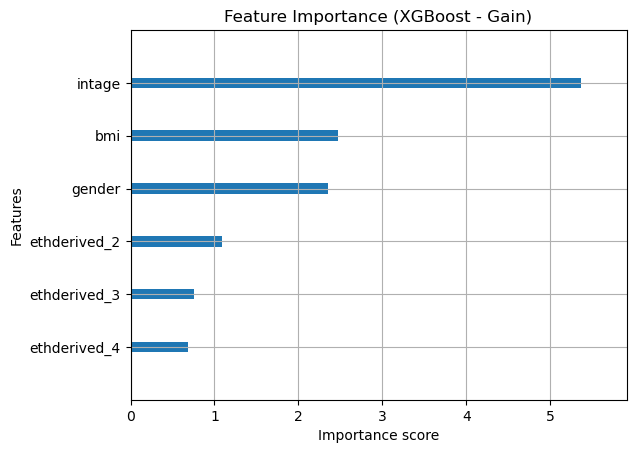

In [15]:
# Step 0. 导入依赖
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

# Step 1. 读取数据
file_path = "C:/Users/Candy/Desktop/merged_all.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

print("原始数据规模:", df.shape)

# Step 2. 计算平均血压
df["sbp_mean"] = df[["bp1systolic1", "bp1systolic2", "bp1systolic3"]].mean(axis=1, skipna=True)
df["dbp_mean"] = df[["bp1diastolic1", "bp1diastolic2", "bp1diastolic3"]].mean(axis=1, skipna=True)

# 血压分组函数
def classify_bp(sbp, dbp):
    if pd.isna(sbp) or pd.isna(dbp):
        return np.nan
    if sbp < 120 and dbp < 80:
        return "optimal"
    elif sbp < 130 and dbp < 85:
        return "normal"
    elif sbp < 140 and dbp < 90:
        return "high_normal"
    else:
        return "hypertensive"

df["bp_group"] = df.apply(lambda row: classify_bp(row["sbp_mean"], row["dbp_mean"]), axis=1)
df = df.dropna(subset=["bp_group"])  # 删除缺失 outcome

# 编码 outcome
bp_mapping = {"optimal":0, "normal":1, "high_normal":2, "hypertensive":3}
df["bp_group_code"] = df["bp_group"].map(bp_mapping)

print("分组后数据规模:", df.shape)

# Step 3. 协变量处理
# 标准化连续变量
scaler = StandardScaler()
df[["intage","bmi"]] = scaler.fit_transform(df[["intage","bmi"]])

# 性别转数值
df["gender"] = df["gender"].astype("category").cat.codes  # 0=male,1=female

# 种族 one-hot 编码
df = pd.get_dummies(df, columns=["ethderived"], drop_first=True)

# 构建自变量矩阵
feature_cols = ["intage","bmi","gender"] + [c for c in df.columns if c.startswith("ethderived_")]
X = df[feature_cols]
y = df["bp_group_code"]

print("最终建模样本量:", X.shape[0], "特征数:", X.shape[1])

# Step 4. XGBoost 模型训练
clf_xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=4,
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

clf_xgb.fit(X, y)

# Step 5. 预测 & 评估
y_pred_xgb = clf_xgb.predict(X)

print("\nXGBoost 分类报告:")
print(classification_report(y, y_pred_xgb, target_names=bp_mapping.keys()))

# Step 6. 特征重要性可视化
plt.figure(figsize=(8,6))
plot_importance(clf_xgb, importance_type="gain", show_values=False)
plt.title("Feature Importance (XGBoost - Gain)")
plt.show()

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. 读取数据
file_path = "C:/Users/Candy/Desktop/merged_all.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# 2. 计算平均血压
df["sbp_mean"] = df[["bp1systolic1", "bp1systolic2", "bp1systolic3"]].mean(axis=1, skipna=True)

# 去掉缺失值
df = df.dropna(subset=["sbp_mean", "intage", "bmi", "gender"])

# 3. 构造特征
def sigmoid(x, k=0.1, c=46):
    return 1 / (1 + np.exp(-k*(x-c)))

df["age_sigmoid"] = sigmoid(df["intage"])
df["time_sigmoid"] = sigmoid(df["intage"], k=0.05, c=60)  # 举例用 age 代替 time

# gender 转数值
df["gender_code"] = df["gender"].astype("category").cat.codes

# 4. 构建 X, y
X = df[["age_sigmoid", "bmi", "gender_code", "time_sigmoid"]]
y = df["sbp_mean"]

# 5. 拟合线性回归
model = LinearRegression()
model.fit(X, y)

# 6. 输出结果
print("回归系数:", model.coef_)
print("截距:", model.intercept_)

# 7. 预测与评估
y_pred = model.predict(X)
print("MSE:", mean_squared_error(y, y_pred))
print("R²:", r2_score(y, y_pred))

回归系数: [ 6.77805816  1.01939047 -3.71288211 53.34492798]
截距: 69.59433319979009
MSE: 489.2025632265987
R²: 0.20037242862596127
